# Model Selection - Hyper-parameter Tuning

<h2>Background</h2>

I found that running different models through Jupyter notebook just wasn't stable enough. The process would either crash or hang and found the speed much slower than if I ran them as a standalone programs. I also found that if I broke the steps down into different programs, it would run faster and was more reliable for me to check on results.

Here is a list of programs that I used to generate various feature files and results:

| File Name | Description | Helper Classes | Sample Config File |
|-----------|-------------|----------------|--------------------|
| [tsv_to_csv.py](tsv_to_csv.py) | I found that pandas did not handle reading in raw amazong review files (tsv) correctly. There were line breaks in the data file that caused pandas to be confused and would merge in multiple lines into one column cell which would sku the data. Needed to write this to convert the tsv to csv so pandas can read the data properly | N/A | N/A |
| [amazon_review_preprocessor.py](amazon_review_preprocessor.py) | Takes in converted amazon review csv file does pre-processing/cleaning of the data | [util.TextProcessor.py](util/TextProcessor.py) | N/A |
| [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py) | Takes in preprocessed file generated from [amazon_review_preprocessor.py](amazon_review_preprocessor.py) and generate BoW or TFIDF feature files with different parameters. Parameters supported: various max_df, min_df, ngrams | [nlp.feature_util.py](nlp/feature_util.py) | [2019-05-21-amazon_review_feature_generation_config-bow.py](config/2019-05-21-amazon_review_feature_generation_config-bow.csv) |
| [generate_lda_features.py](generate_lda_features.py) | After processing data through [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py), I used this program to do Topic Modeling using LDA with this program. Current setting picks 20 topics and generate resulting data files | N/A | [2019-05-21-amazon_review_generate_lda_feature_config-tfidf.cvs](config/2019-05-21-amazon_review_generate_lda_feature_config-tfidf.csv) |
| [run_classifiers.py](run_classifiers.py) | This was originally a python notebook that would take hours and hours to run. But the original notebook also combined the function of generating BoW and TF-IDF with various parameters encoding as well as running KNN and LogisticRegression with various parameters. This also generates reports using sklearn's classification_report for different models which we will interpret here. | [models/ClassifierRunner.py](models.ClassifierRunner.py) | [2019-05-23-run_classifiers-config.csv](config/template-run_classifiers.csv) |


<h2>Models</h2>

From previous notebooks, the 3 best models out of all models we tried were: lightGBM, Logistic Regression with balanced weight, and CatBoost


<h3>Model Keys</h3>

| Model Name | Description |
|------------|-------------|
| LRB100 | Logistic Regression with class_weight set to 'balanced'. 100 iterations |
| CB | CatBoost |
| lGBM | lightGBM |


<h2>Data</h2>

There was definitely improvements in F1 score as well as Recall when using 100k samples vs 50k samples. However, because of the time it takes to run different models, I had to narrow down the sample size to 50k.

For CatBoost and Logistic Regression - it took around 6 hours or more to find the best model using RandomizedCV

The Rest of this notebook will go into details around this process




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np


%matplotlib inline
sns.set()

In [2]:
# function that we will use later

def get_score_columns(df:pd.DataFrame) -> (list, list, list):
    CLASS_F1_COLS = [col for col in df.columns if len(re.findall(r'^(\d.+score)',col)) > 0]
    CLASS_F1_COLS.append("label")
#     print(CLASS_F1_COLS)

    CLASS_PRECISION_COLS = [col for col in df.columns if len(re.findall(r'^(\d+_precision)',col)) > 0]
    CLASS_PRECISION_COLS.append("label")
#     print(CLASS_PRECISION_COLS)

    CLASS_RECALL_COLS = [col for col in df.columns if len(re.findall(r'^(\d+_recall)',col)) > 0]
    CLASS_RECALL_COLS.append("label")
#     print(CLASS_RECALL_COLS)
    
    return CLASS_F1_COLS, CLASS_PRECISION_COLS, CLASS_RECALL_COLS

In [3]:
# function to print mutltiple histograms
def plot_score_histograms(df:pd.DataFrame):
    MODELS = df["model_name"].unique()
    f1_cols, precision_cols, recall_cols = get_score_columns(df)
    for model in MODELS:
        model_report = df[df["label"].str.startswith(f'{model}-')]

        pos = list(range(len(model_report)))
        width = 0.15
        f, a = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, len(model_report) * 1))
        column_dict = { "F1": f1_cols, "Precision": precision_cols, "Recall": recall_cols }

        # sort the report in reverse order so we see the models top down
        report_reverse = model_report.sort_values("label", ascending=False)

        index = 0
        for title, columns in column_dict.items():
            columns_copy = columns.copy()
            columns_copy.remove("label")
            # sort in reverse order so it goes top-down and 5 is at the bottom
            columns_copy.sort(reverse=True)

            offset = 0
            for col in columns_copy:
        #         print(f'Plotting {col}')
                a[index].barh([p + offset for p in pos], 
                        report_reverse[col], 
                        width, 
        #                 align="edge",
        #                 alpha=0.5, 
                        tick_label=report_reverse["label"].tolist(),
                        orientation="horizontal") 
                offset += width
                a[index].set_title(title)
                a[index].set_xlim(0, 1.0)
            index += 1

In [4]:
def plot_macro_data(df:pd.DataFrame, cv=False):
    df["label"] = df.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)

    df = df.sort_values(["label"])
                                                 
    f, a = plt.subplots(1, 1, figsize=(20,5))

    g = sns.lineplot(data=df, x="label", y="macro avg_f1-score", label="avg_f1-score", ax=a, color="r")
    g = sns.lineplot(data=df, x="label", y="macro avg_precision", label="avg_precision", ax=a, color="b")
    g = sns.lineplot(data=df, x="label", y="macro avg_recall", label="avg_recall", ax=a, color="g")
    g.set_xticklabels(labels=df["label"], rotation=90)
    g.set_ylabel("percentage")
    g.set_title("Macro Average Scores And Total Time")
    g.legend(loc="upper left")


    ax2 = a.twinx()

    x = df.label.tolist()
    predict_times = df.total_time_min.tolist()
    fit_times = (df.file_load_time_min + df.train_time_min).tolist()
    if cv:
        cv_times = (df.cv_time_min + df.file_load_time_min + df.train_time_min)
    load_times = df.file_load_time_min.tolist()

    g = sns.barplot(data=df, x="label", y="predict_time_min", label="Predict Time", ax=ax2, color="c", alpha=0.5)
    if cv:
        g = sns.barplot(x=x, y=cv_times, label="CV Time", ax=ax2, color="tab:green", alpha=0.5)
    g = sns.barplot(x=x, y=fit_times, label="Fit Time", ax=ax2, color="tab:orange", alpha=0.5)
    g = sns.barplot(x=x, y=load_times, label="File Load Time", ax=ax2, color="tab:blue", alpha=0.5)
    ax2.tick_params(axis='y', labelcolor="c")
    _ = ax2.legend(loc="upper right")

# SMOTE

Also, in our previous notebook we can see there is an imbalance in data with 2-star ratings having the least amount of samples. We synthetically generated samples for minority classes for our training data in this notebook with the following code

``` python
            grouped_df = Y_train.reset_index().groupby("star_rating").count()
            sm = SMOTE(random_state=2, sampling_strategy={1: int(round(grouped_df.iloc[0] * 1.67)),
                                                          2: int(round(grouped_df.iloc[1] * 2.00)),
                                                          3: int(round(grouped_df.iloc[2] * 1.67)),
                                                          4: int(round(grouped_df.iloc[3] * 1.67))}
                       )

            X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train.ravel())

            X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
            Y_train = pd.DataFrame(Y_train_res, columns=["star_rating"])
```

The following is distribution of star ratings after SMOTE

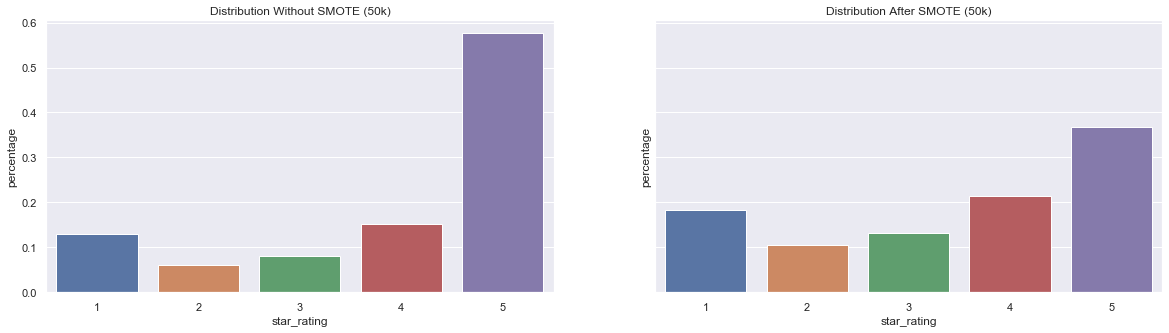

In [5]:
f, a = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 5))
star50k_pd = pd.read_csv("dataset/feature_files/50000-hist.csv")
star50k_pd["percentage"] = star50k_pd["count"].apply(lambda x: x / pd.Series.sum(star50k_pd["count"]))
smote50k_pd = pd.read_csv("dataset/feature_files/50000smote-hist.csv")
smote50k_pd["percentage"] = smote50k_pd["count"].apply(lambda x: x / pd.Series.sum(smote50k_pd["count"]))

sns.barplot(data=star50k_pd, x="star_rating", y="percentage", ax=a[0])
_ = a[0].set_title("Distribution Without SMOTE (50k)")
sns.barplot(data=smote50k_pd, x="star_rating", y="percentage", ax=a[1])
_ = a[1].set_title("Distribution After SMOTE (50k)")

# Here is a comparison of SMOTE vs no-SMOTE with 100k samples

There is a slight improvement in F1 score for 2-star ratings. Mostly no difference in Precision and Recall with the exception that Precision seems to be lower when using SMOTE for CatBoost and slightly lower for Logistic Regression


Oveall:

* Logistic Regression tends to do better than the other 2 models in overall test accuray - F1 score
* Logistic Regression also does better than the other 2 models when it comes to recall - meaning that it's better at not having false negatives
* CatBoost and lightGBM both does better than Logistic Regression when it comes to precision, meaning that it finds less false positives

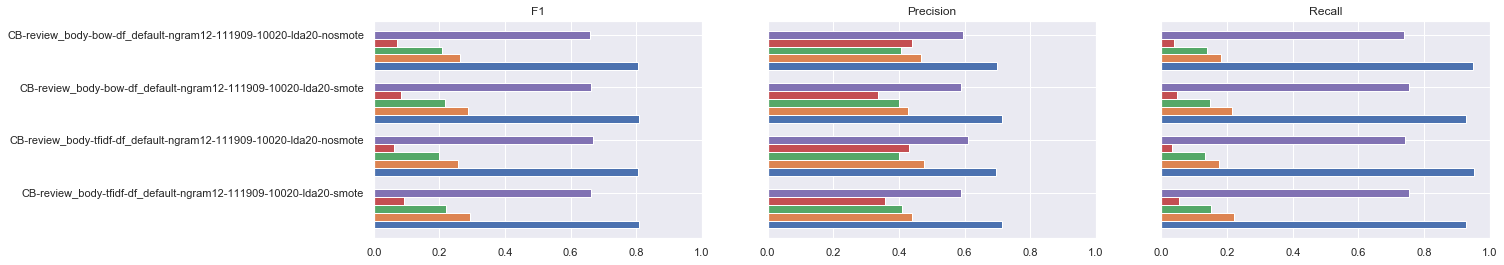

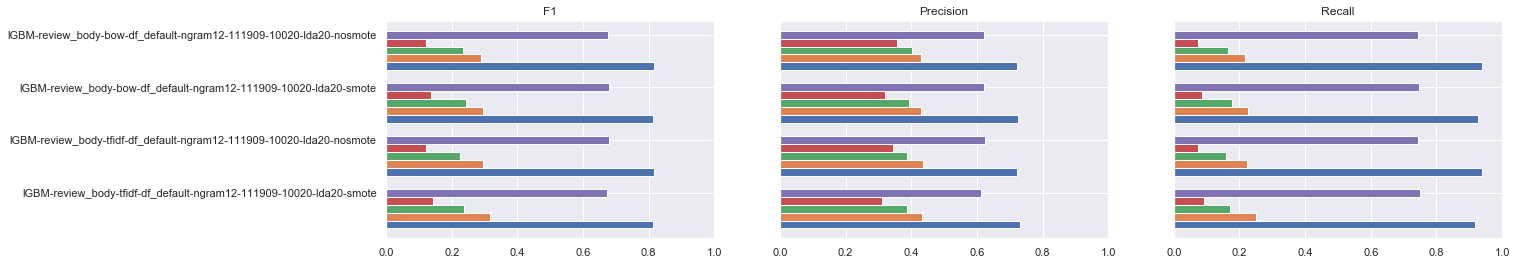

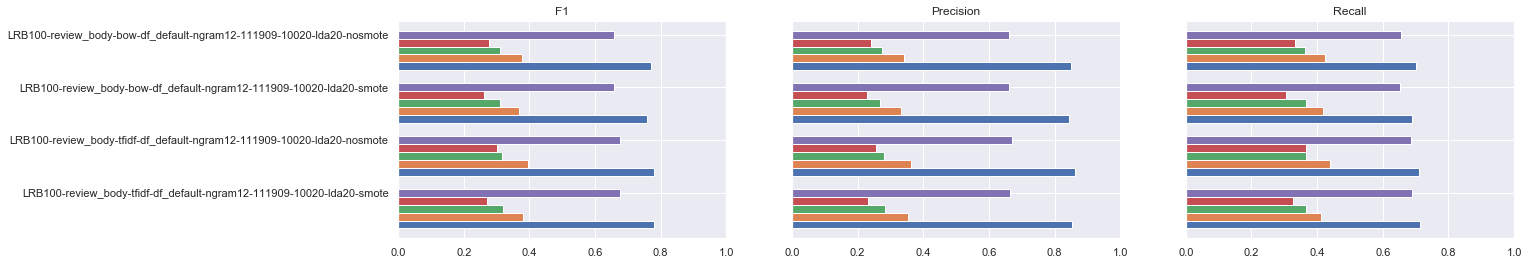

In [6]:
smote_report_pd = pd.read_csv('reports/2019-05-31-run_classifiers-report-smotevsnosmote.csv')
smote_report_pd["label"] = smote_report_pd.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
plot_score_histograms(smote_report_pd)
f1_cols, precision_cols, recall_cols = get_score_columns(smote_report_pd)


# Sample Size Comparison 50k vs 100k


When you average all star ratings, overall does better for recall and precision. However, F1 scores overall for CatBoost and lightGBM is better

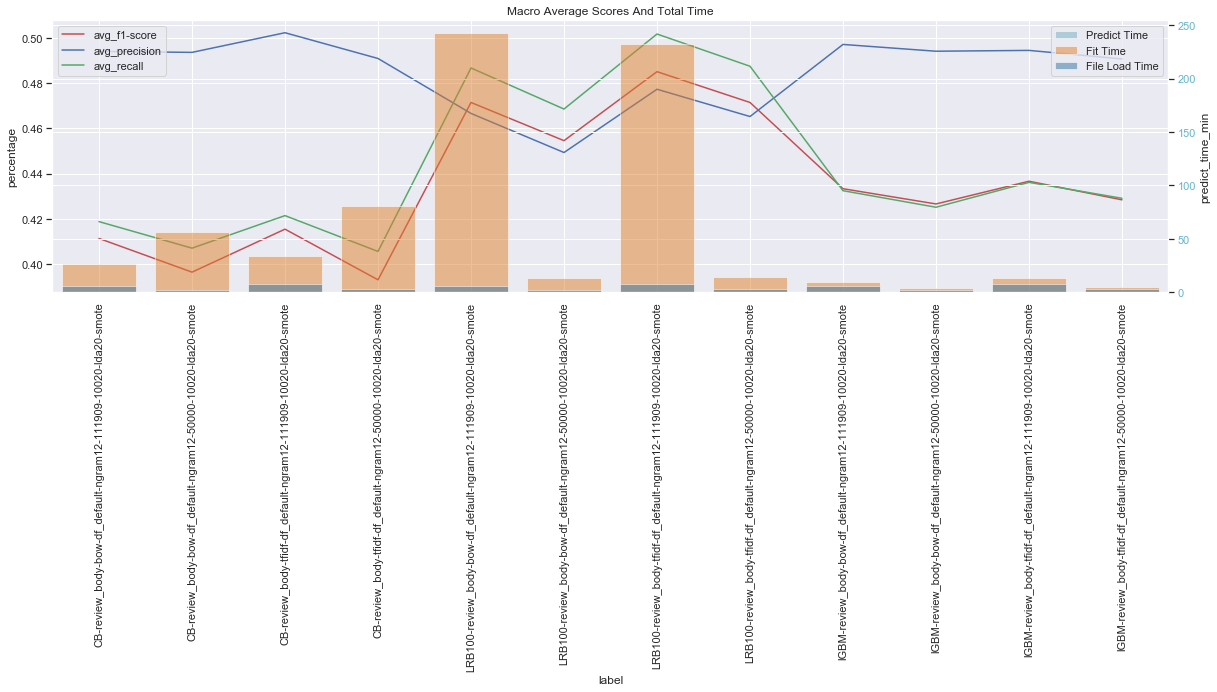

In [7]:
size_report_df = pd.read_csv('reports/2019-05-31-run_classifiers-report-50v100.csv')
plot_macro_data(size_report_df)


You can see a difference in F1 score as well as Precision when comparing 50k vs 100k samples. Most significant differences are in the 2-Star and 4-Star ratings. However, because of it time it takes to run the models for tuning, I had to cut down the sample size to 50k

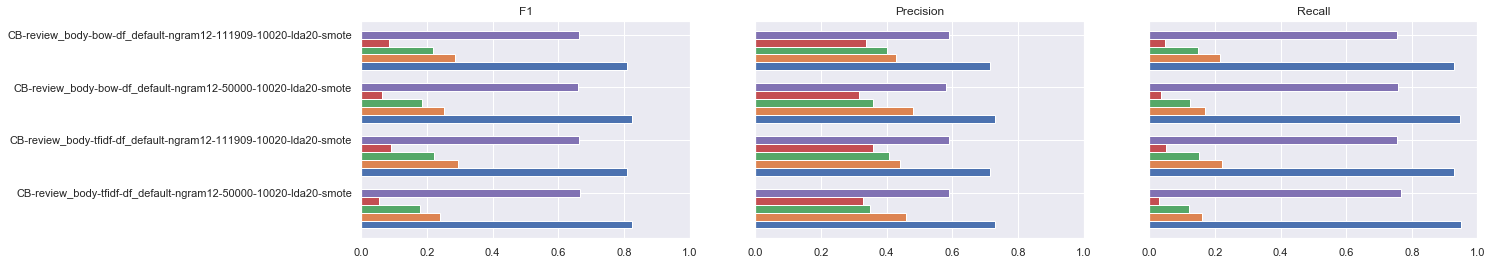

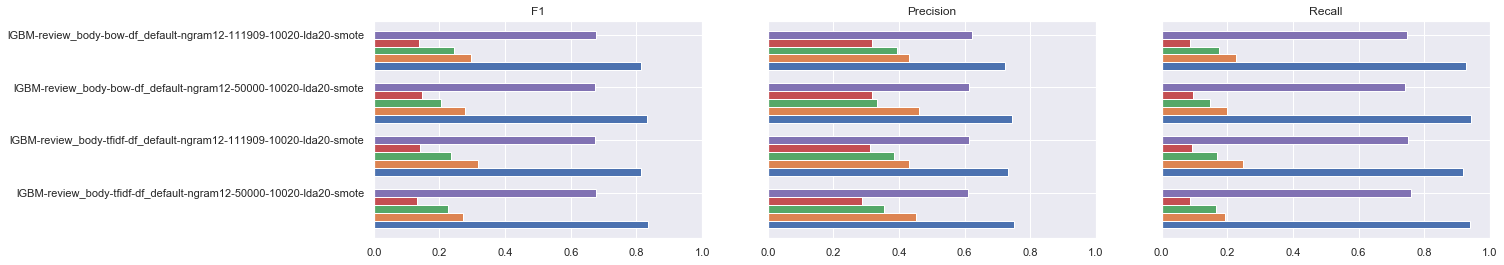

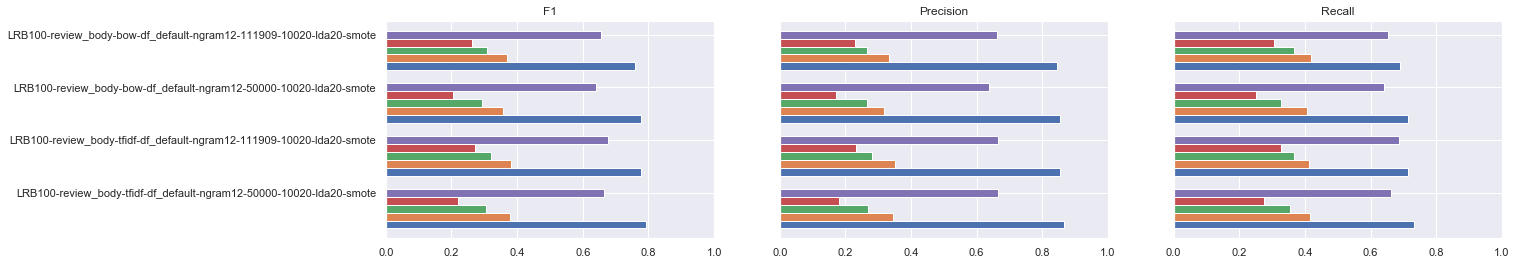

In [8]:
smote_report_pd = pd.read_csv('reports/2019-05-31-run_classifiers-report-50v100.csv')
smote_report_pd["label"] = smote_report_pd.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
plot_score_histograms(smote_report_pd)


# Hyperparameter Tuning

For tuning hyperparameters, I had to use RandomizedSearchCV for CatBoost and lightGBM because of the number of recommended parameters to tune. My first attempt that used GridSearchCV for CatBoost took over 8 hours and it will wasn't finished. For Logistic Regression, I used the GridSearchCV since I only tuned the regression parameter 'C'

Tuning was done with 50k samples using both BoW and TFIDF with LDA with 20 topics and SMOTE

Here are code snippets on parameters that I tuned for various models. Full code can be found in [parameter_tunning.py](parameter_tunning.py)

<h3>Logistic Regression</h3>

``` python
            parameters = {'C': [1, 10, 100]}
            trainer = LogisticRegression(random_state=0, solver='lbfgs',
                                         multi_class='auto',
                                         class_weight='balanced',
                                         max_iter=args.lr_iter, n_jobs=args.n_jobs,
                                         verbose=1)
```

<h3>CatBoost</h3>

``` python
            parameters = {"depth": sp_randint(4, 10),
                          "l2_leaf_reg": sp_randint(1, 100),
                          "iterations": sp_randint(2, 10)
                          }
            trainer = CatBoostClassifier(random_seed=1, loss_function='MultiClass', objective='MultiClass')
```

<h3>lightGBM</h3>

``` python
            parameters = {"num_leaves": sp_randint(31, 124),
                          "min_data_in_leaf": sp_randint(20, 80),
                          "max_depth": sp_randint(4, 16)}
            trainer = lgb.LGBMClassifier(objective="multiclass",
                                         seed=1)
```

<h3>CV Creation Code:</h3>

``` python
def run_cv(trainer, model_name, parameters, x_train, y_train, x_test, y_test, infile, report, timer, use_random=False):
    log.info(f"Starting to train {model_name}\n\tparameters: {parameters}")
    report["model_name"] = model_name
    if use_random:
        cv = RandomizedSearchCV(estimator=trainer, cv=5, param_distributions=parameters, iid=False)
    else:
        cv = GridSearchCV(estimator=trainer, cv=5, param_grid=parameters, iid=False)
    timer.start_timer(CV_TIME_MIN)
    best_model = cv.fit(x_train, y_train)
    timer.end_timer(CV_TIME_MIN)

    log.info(f'Best Estimatator:\n{best_model.best_estimator_}')
    log.info(f'Best Index:\n{best_model.best_index_}')
    log.info(f'Best Score:\n{best_model.best_score_}')
    log.info(f'Best Params:\n{best_model.best_params_}')

    report[Keys.PARAMETERS] = parameters
    report["best_estimator"] = best_model.best_estimator_
    report["best_index"] = best_model.best_index_
    report["best_score"] = best_model.best_score_
    report["best_params"] = best_model.best_params_

    timer.start_timer(Keys.TRAIN_TIME_MIN)
    model = best_model.fit(x_train, y_train)
    timer.end_timer(Keys.TRAIN_TIME_MIN)

    timer.start_timer(MODEL_SAVE_TIME_MIN)
    _, infile_basename = fu.get_dir_basename(infile)
    joblib_filename = f"models/{infile_basename}-{model_name}-{sm_desc}.pkl"
    with open(joblib_filename, 'wb') as file:
        joblib.dump(model, file)
    report["model_file"] = joblib_filename
    timer.end_timer(MODEL_SAVE_TIME_MIN)

    timer.start_timer(Keys.PREDICT_TIME_MIN)
    y_predict = model.predict(x_test)
    timer.end_timer(Keys.PREDICT_TIME_MIN)

    c_report = classification_report(y_test, y_predict, output_dict=True)
    report = add_dict_to_dict(report, c_report)
    report.update(timer)

    return report
```


<h3>Search Time</h3>

To Find the best models for both BoW and TFIDF, here is a summary of time it took to run:

| Model | Time To Complete | Computer |
|-------|------------------|------|
| lightGBM | 6 hours | MBP 2018
| Logistic Regression | 16.5 hours | Mac Mini 2011 |
| CatBoost | 12.5 hours | MBP 2018 |


NOTE: I will not going to go into times too much because I had to split the workload between 2 different computer in hopes they will finish in time. For Logistic Regression, I am actually running this on my old 2011 Mac Mini with a dual-core i5 1.5GHz processor using both cores. The rest was done on my 2018 MBP with 3 cores i5 2.3GHz processor

## Here are the parameters found for best models


In [15]:
tuning_report_df = pd.read_csv('reports/2019-06-04-hyperparameter_tuning-report.csv')
tuning_report_df["feature_set"] = tuning_report_df.description.apply(lambda x: x.split("-")[1])
tuning_report_df = tuning_report_df.sort_values(["model_name", "feature_set"])
pd.set_option("display.max_colwidth", 200)
tuning_report_df[["model_name", "feature_set", "best_params"]].head()

,model_name,feature_set,best_params
4,CB,bow,"{'depth': 7, 'iterations': 9, 'l2_leaf_reg': 7}"
5,CB,tfidf,"{'depth': 9, 'iterations': 6, 'l2_leaf_reg': 5}"
2,LRB100,bow,{'C': 1}
3,LRB100,tfidf,{'C': 10}
0,lGBM,bow,"{'max_depth': 15, 'min_data_in_leaf': 31, 'num_leaves': 118}"


## Compare Results from Best Model to Model Without Tuning

Unfortunately, things are not looking so good after tuning our hyperparameters. Almost no improvements overall, with even slightly worse results for star rating 2 which is our problematic category. CatBoost seems to be doing the worst after tuning.


| - | BoW | TFIDF |
|----|------|------|
| CatBoost | Tuned parameters are worse than default | Tuned parameters are worse than default |
| Logistic Regression | slight improvement on F1 score, precision, and recall for Star rating 2. | Recall improved slightly but worse in both F1 and precision |
| lightGBM | No Difference in F1 score. Worse performance in Star rating 2 for Precision. Almost the same in Recall | Slight boost in F1 score for star rating 2 and recall. Everything else looks the same |

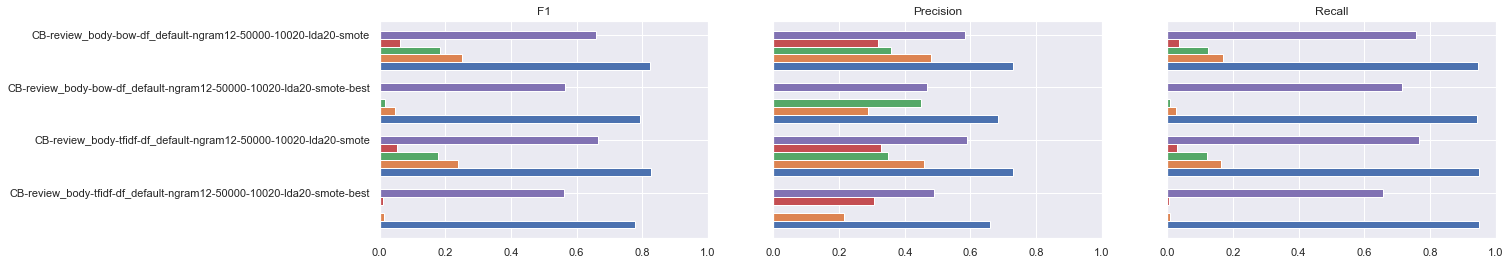

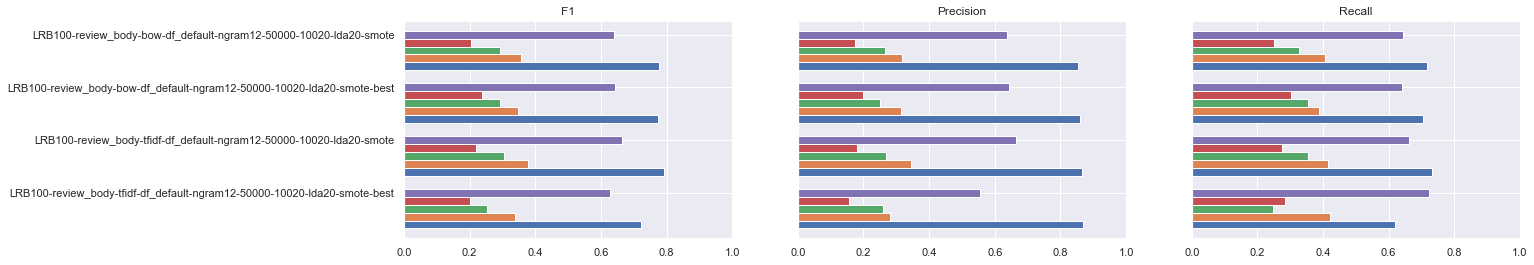

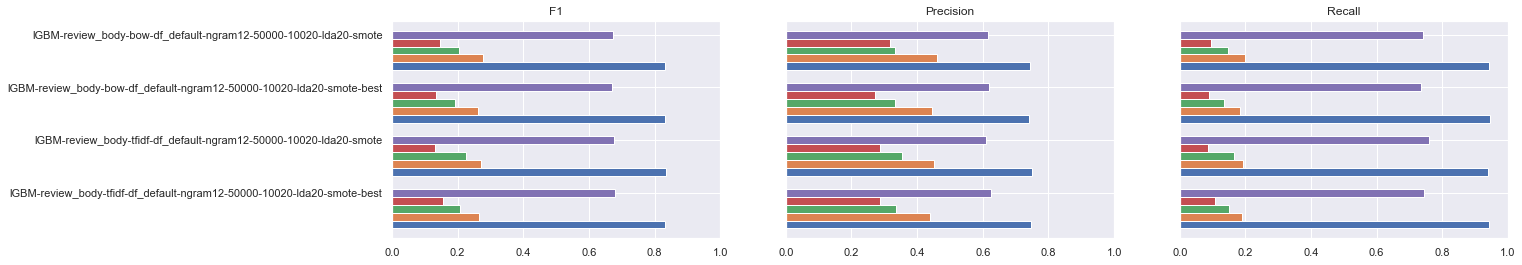

In [11]:
compare_report_df = pd.read_csv('reports/2019-06-04-hyperparameter_tuning-report-compare.csv')
compare_report_df["label"] = compare_report_df.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
compare_report_df["feature_set"] = compare_report_df.description.apply(lambda x: x.split("-")[1])
compare_report_df = compare_report_df.sort_values(["model_name", "feature_set", "best"])
plot_score_histograms(compare_report_df)


### Let's Look at this data in Table Format

In [12]:
f1_cols, precision_cols, recall_cols = get_score_columns(compare_report_df)
models = compare_report_df.model_name.unique()
feature_sets = compare_report_df.feature_set.unique()
f1_cols.remove("label")
f1_cols.insert(0, "best")
precision_cols.remove("label")
precision_cols.insert(0, "best")
recall_cols.remove("label")
recall_cols.insert(0, "best")

for model in models:
    for feature_set in feature_sets:
        print(f'\n{model}-{feature_set}:')
        print(compare_report_df[(compare_report_df.model_name == model) &
                         (compare_report_df.feature_set == feature_set)][f1_cols].head())
        print("")
        print(compare_report_df[(compare_report_df.model_name == model) &
                         (compare_report_df.feature_set == feature_set)][precision_cols].head())
        print("")
        print(compare_report_df[(compare_report_df.model_name == model) &
                         (compare_report_df.feature_set == feature_set)][recall_cols].head())
        print("")


CB-bow:
   best  1_f1-score  2_f1-score  3_f1-score  4_f1-score  5_f1-score
4    No    0.658699    0.063107    0.183150    0.251665    0.824767
10  Yes    0.565207    0.000000    0.017358    0.046125    0.793144

   best  1_precision  2_precision  3_precision  4_precision  5_precision
4    No     0.582160     0.317073     0.359195     0.480226     0.730069
10  Yes     0.467574     0.000000     0.450000     0.287356     0.684135

   best  1_recall  2_recall  3_recall  4_recall  5_recall
4    No  0.758410   0.03504  0.122911  0.170512  0.947694
10  Yes  0.714373   0.00000  0.008850  0.025075  0.943476


CB-tfidf:
   best  1_f1-score  2_f1-score  3_f1-score  4_f1-score  5_f1-score
7    No    0.666667    0.054388    0.178493    0.239348    0.825463
11  Yes    0.561275    0.010596    0.000000    0.013599    0.778156

   best  1_precision  2_precision  3_precision  4_precision  5_precision
7    No     0.590288     0.328358     0.348571     0.458156     0.729826
11  Yes     0.489964     0.30